In [142]:
import copy
import random
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from sklearn.metrics import confusion_matrix
from torch import nn, optim
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [143]:
class AddRandomNoise(object):
    def __init__(self, noise_range=(0, 0.3)):
        self.noise_range = noise_range

    def __call__(self, img):
        noise_level = random.uniform(self.noise_range[0], self.noise_range[1])
        noise = torch.randn_like(img) * noise_level
        return img + noise


training_transforms = transforms.Compose(
    [
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        AddRandomNoise(noise_range=(0, 0.2)),
    ]
)

torch.manual_seed(42)

test_dataset = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())
train_dataset_augmented = torchvision.datasets.MNIST(root='data', train = True, transform = training_transforms, download = True)
train_dataset_clear = torchvision.datasets.MNIST(root='data', train = True, transform = transforms.ToTensor(), download = True)

# Splitting the correct datasets
all_indices = list(range(len(train_dataset_clear)))

all_indices_clear = list(range(len(train_dataset_clear)))

train_indices_clear, validation_indices_clear = train_test_split(all_indices_clear, test_size=0.1, random_state=42)

train_dataset = torch.utils.data.Subset(train_dataset_augmented, train_indices_clear)
validation_dataset = torch.utils.data.Subset(train_dataset_clear, validation_indices_clear)

print(len(train_dataset_augmented) ,len(train_dataset), len(validation_dataset))

60000 54000 6000


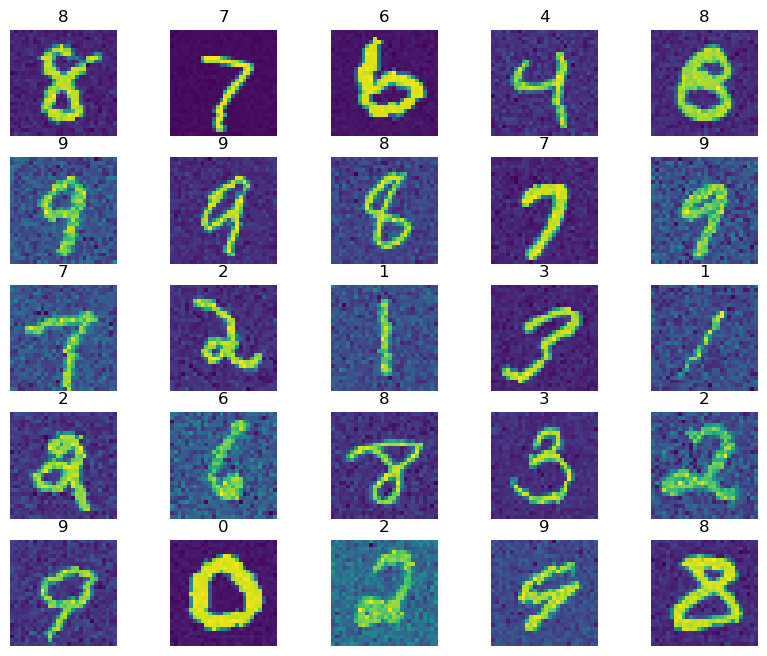

In [144]:
ds = train_dataset

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx] # type: ignore
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")

In [145]:
batch_size = 64

# Create data loaders for training, validation, and test sets
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


print(len(train_data_loader.dataset)) # type: ignore
print(len(valid_data_loader.dataset)) # type: ignore
print(len(test_data_loader.dataset)) # type: ignore

54000
6000
10000


In [146]:
# in: 28x28
def create_model():
    return nn.Sequential(
        nn.Conv2d(
            in_channels=1,
            out_channels=8,
            kernel_size=8,
            stride=1,
            padding=6,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(
            in_channels=8,
            out_channels=40,
            kernel_size=3,
            stride=1,
            padding=0,
        ),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=3, stride=3),
        nn.Flatten(),
        nn.Linear(in_features=640, out_features=320),
        nn.ReLU(),
        nn.Linear(in_features=320, out_features=160),
        nn.ReLU(),
        nn.Linear(in_features=160, out_features=10),
    )
    
example_model = create_model()
x = torch.zeros(1, 1, 28, 28)

for m in example_model:
    x = m(x)
    print(x.size(), m)

torch.Size([1, 8, 33, 33]) Conv2d(1, 8, kernel_size=(8, 8), stride=(1, 1), padding=(6, 6))
torch.Size([1, 8, 33, 33]) ReLU()
torch.Size([1, 8, 16, 16]) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 40, 14, 14]) Conv2d(8, 40, kernel_size=(3, 3), stride=(1, 1))
torch.Size([1, 40, 14, 14]) ReLU()
torch.Size([1, 40, 4, 4]) AvgPool2d(kernel_size=3, stride=3, padding=0)
torch.Size([1, 640]) Flatten(start_dim=1, end_dim=-1)
torch.Size([1, 320]) Linear(in_features=640, out_features=320, bias=True)
torch.Size([1, 320]) ReLU()
torch.Size([1, 160]) Linear(in_features=320, out_features=160, bias=True)
torch.Size([1, 160]) ReLU()
torch.Size([1, 10]) Linear(in_features=160, out_features=10, bias=True)


In [147]:
32 * 4 *4

512

In [148]:
def validate(model, data, device):
    total = 0
    correct = 0
    for images, labels in data:
        images = images.to(device)
        labels = labels.to(device)

        x = model(images)
        _, pred = torch.max(x, 1)
        pred = pred.cpu()  # Move predictions back to CPU if they were on GPU
        total += labels.size(0)
        correct += torch.sum(pred == labels.cpu())  # Move labels back to CPU for comparison

    return correct * 100. / total

In [149]:
def train(writer, numb_epoch=3, lr=0.01, device="cpu", log=True, step_size = 5, gamma = 0.65):
    accuracies = []
    best_model = cnn = create_model().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    max_accuracy = 0
    max_acc_epoch = 0
    max_count = 0
    for epoch in range(numb_epoch):
        for images, labels in train_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = loss_func(pred, labels)
            loss.backward()
            optimizer.step()

        accuracy_test = float(validate(cnn, valid_data_loader, device))
        accuracies.append(accuracy_test)
        scheduler.step()
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy_test
            max_acc_epoch = epoch
            max_count+=1
            print(f"-Saving Best Model with Accuracy: {accuracy_test}%, epoch: {max_acc_epoch}")
        print('Epoch:', epoch+1, "Test Accuracy :", accuracy_test, '%', "Learning rate: ", optimizer.param_groups[0]["lr"] )
        if log:
            writer.add_scalar("Accuracy/Epoch", accuracy_test, epoch)
            writer.add_scalar("Learning rate/Epoch", optimizer.param_groups[0]["lr"], epoch)
            writer.add_scalar("Best result/Epoch", max_accuracy, epoch)
    plt.plot(accuracies)
    plt.plot(max_acc_epoch, max_accuracy, 'o')
        
    return best_model, max_accuracy

In [150]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")

No Cuda Available


-Saving Best Model with Accuracy: 97.81666564941406%, epoch: 0
Epoch: 1 Test Accuracy : 97.81666564941406 % Learning rate:  0.003
-Saving Best Model with Accuracy: 98.28333282470703%, epoch: 1
Epoch: 2 Test Accuracy : 98.28333282470703 % Learning rate:  0.003
-Saving Best Model with Accuracy: 98.63333129882812%, epoch: 2
Epoch: 3 Test Accuracy : 98.63333129882812 % Learning rate:  0.003
-Saving Best Model with Accuracy: 98.75%, epoch: 3
Epoch: 4 Test Accuracy : 98.75 % Learning rate:  0.0021
-Saving Best Model with Accuracy: 98.81666564941406%, epoch: 4
Epoch: 5 Test Accuracy : 98.81666564941406 % Learning rate:  0.0021
Epoch: 6 Test Accuracy : 98.78333282470703 % Learning rate:  0.0021
-Saving Best Model with Accuracy: 99.0999984741211%, epoch: 6
Epoch: 7 Test Accuracy : 99.0999984741211 % Learning rate:  0.0021
Epoch: 8 Test Accuracy : 98.83333587646484 % Learning rate:  0.0014699999999999997
Epoch: 9 Test Accuracy : 99.08333587646484 % Learning rate:  0.0014699999999999997
Epoch: 10

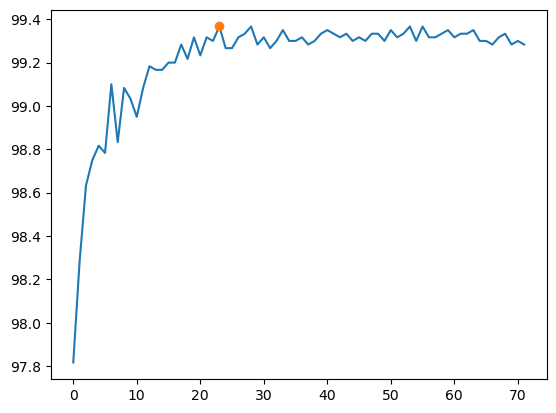

In [151]:
run_name = "36 - Longer - Bigger convs, linear halfer - Test"
writer = SummaryWriter(f'./runs/{run_name}')
model, max_accuracy = train(writer, numb_epoch=72, device=device, log=True, step_size=4, gamma=0.7, lr=0.003) # type: ignore

writer.flush()
writer.close()

In [152]:
ts = datetime.now().strftime('%Y%m%d%H%M%S')

torch.save(model.state_dict(), f'model_{ts}_{max_accuracy:0.3f}.pth')

In [153]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)

            x = model(images)
            _, pred = torch.max(x, 1)
            pred = pred.data.cpu()
            
            correct_predictions += torch.sum(pred == labels.data.cpu()).item()
            total_samples += labels.size(0)

            y_pred.extend(list(pred.numpy()))
            y_true.extend(list(labels.numpy()))

    accuracy = (correct_predictions / total_samples) * 100.0

    return np.array(y_pred), np.array(y_true), accuracy

In [154]:
y_pred, y_true, test_accuracy = predict_dl(model, test_data_loader)

print("Train Accuracy: ", max_accuracy, "%")
print("Test Accuracy: ", test_accuracy, "%")
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

Train Accuracy:  99.36666870117188 %
Test Accuracy:  99.36 %


,0,1,2,3,4,5,6,7,8,9
0,979,0,0,0,0,0,0,1,0,0
1,0,1133,0,1,0,0,0,1,0,0
2,0,1,1026,1,0,0,0,4,0,0
3,0,0,2,1008,0,0,0,0,0,0
4,0,0,0,0,978,0,1,1,0,2
5,2,0,0,6,0,879,3,1,0,1
6,3,3,0,1,2,1,947,0,1,0
7,0,2,3,0,0,0,0,1022,0,1
8,1,0,1,1,0,0,0,0,971,0
9,0,1,0,0,9,2,0,4,0,993
